In [1]:
import torch
import torchaudio
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nnAudio.features import CQT

In [31]:
def extract_cqt_transformer(sample_rate):
    """
    创建并返回CQT变换对象。
    
    CQT（Constant-Q Transform）是一种时频分析方法，具有对数频率分辨率，
    在低频处有更高的频率分辨率，在高频处有更高的时间分辨率。
    CQT特别适合音乐信号分析，因为它的频率分布与音乐音符的对数关系相匹配。
    
    Args:
        sample_rate (int): 音频采样率，决定了频谱分析的频率范围
        n_bins (int): CQT频率bins的数量
    
    Returns:
        Spectrogram.CQT: 初始化完成的CQT对象
        
    参数说明:
        - sr: 采样率
        - n_bins: CQT频率bins数量，决定输出特征维度
        - bins_per_octave: 每个八度音程的bins数量，通常为12
        - hop_length: 帧移，控制时间分辨率
        - fmin: 最低频率，通常设为C1音符频率
        - window: 窗函数类型，'hamming'提供良好的频率泄漏控制
        - center: 是否对信号进行中心填充
        - pad_mode: 填充模式，'reflect'进行镜像填充
        - trainable: 是否允许训练过程中调整参数
        - output_format: 输出格式，'Magnitude'表示幅度谱
        - verbose: 是否显示详细信息
    """
    # 初始化CQT变换对象
    cqt_transformer = CQT(
        sr=sample_rate,
        bins_per_octave=12,
        n_bins=80,
        hop_length=512,
        fmin=32.7, # C1音符频率
        window='hamming',
        center=True,
        pad_mode='reflect',
        norm=1,
        trainable=False,
        output_format='Magnitude',
        verbose=False
    )
    return cqt_transformer

In [15]:
def save_cqt_to_csv(cqt_features, output_csv):
    """
    将CQT特征保存为CSV文件
    :param cqt_features: CQT特征矩阵
    :param output_csv: CSV文件路径
    """
    df = pd.DataFrame(cqt_features)
    df.to_csv(output_csv, index=False, header=False)
    print(f"CQT特征已保存至 {output_csv}")

In [16]:
def plot_cqt_features(cqt_data, sr, output_image=None):
    """
    可视化CQT特征
    :param cqt_data: CQT特征矩阵
    :param sr: 采样率
    :param output_image: 如果提供路径，则保存图片
    """
    plt.figure(figsize=(12, 8))

    cqt_db = librosa.amplitude_to_db(cqt_data, ref=np.max) 
    librosa.display.specshow(cqt_db, sr=sr, hop_length=512, fmin=18.0, x_axis='time', y_axis='cqt_hz', cmap='turbo')
    plt.title("CQT Features")
    plt.xlabel("Time(s)")
    plt.ylabel("CQT(Hz)")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

    if output_image:
        plt.savefig(output_image)
        print(f"CQT特征图已保存至 {output_image}")
    else:
        plt.show()

In [29]:
def extract_cqt_with_harmonics(waveform, sample_rate, harmonics=[1, 2, 3]):
    """
    提取CQT特征及其谐波特征
    
    Args:
        waveform (torch.Tensor or np.ndarray): 输入音频波形
        sample_rate (int): 采样率
        n_bins (int): CQT频率bins数量
        harmonics (list): 要提取的谐波次数列表
    
    Returns:
        np.ndarray: 组合的CQT特征矩阵，形状为 (n_harmonics * n_bins, n_frames)
    """
    # 确保输入为numpy数组
    if isinstance(waveform, torch.Tensor):
        audio_data = waveform.detach().cpu().numpy()
    else:
        audio_data = waveform.squeeze()
    
    bins_per_octave = 12
    nyquist_freq = sample_rate / 2
    features_list = []

    for h in harmonics:
        # 计算谐波的基频
        fmin_harmonic = 32.7 * h  # C1音符频率 * 谐波次数
        safe_bins =[]
        # 动态计算安全的n_bins，确保不超过奈奎斯特频率，公式：fmax = fmin * 2^(n_bins/bins_per_octave)，解得：n_bins = bins_per_octave * log2(fmax/fmin)
        max_safe_ratio = nyquist_freq / fmin_harmonic
        safe_n_bins = int(bins_per_octave * np.log2(max_safe_ratio))
        safe_bins.append(safe_n_bins)
    n_bins = min(safe_bins)

    # 为每个谐波提取CQT特征
    for h in harmonics:
        # 计算谐波的基频
        fmin_harmonic = 32.7 * h  # C1音符频率 * 谐波次数

        # 使用librosa统一提取CQT特征
        harmonic_cqt = librosa.cqt(
            audio_data, 
            sr=sample_rate, 
            hop_length=512,
            n_bins=80,
            fmin=fmin_harmonic,
            bins_per_octave=bins_per_octave
        )
        
        # 取幅度值并添加到特征列表
        features_list.append(np.abs(harmonic_cqt))
    
    # 垂直拼接所有谐波特征
    combined_features = np.vstack(features_list)
    
    return combined_features

In [18]:
def extract_chromagram_from_cqt(waveform, sample_rate):
    """
    从CQT特征中提取色度图（Chromagram）
    色度图将CQT的频率bins映射到12个半音类别
    """
    # 提取CQT特征
    cqt_transformer = extract_cqt_transformer(sample_rate)
    cqt_features = cqt_transformer(waveform)
    cqt_data = cqt_features.squeeze().numpy()
    
    # 计算色度图
    chromagram = librosa.feature.chroma_cqt(C=cqt_data, sr=sample_rate)
    
    return chromagram

def plot_chromagram(chromagram, sr, output_image=None):
    """
    可视化色度图
    """
    plt.figure(figsize=(12, 8))
    
    librosa.display.specshow(chromagram, sr=sr, hop_length=512, 
                            x_axis='time', y_axis='chroma', cmap='turbo')
    plt.title('Chromagram from CQT')
    plt.xlabel('Time(s)')
    plt.ylabel('Pitch Class')
    plt.tight_layout()
    
    if output_image:
        plt.savefig(output_image)
        print(f"色度图已保存至 {output_image}")
    else:
        plt.show()

CQT特征已保存至 cqt_features.csv
CQT特征图已保存至 cqt_features.png
色度图已保存至 cqt_chromagram.png


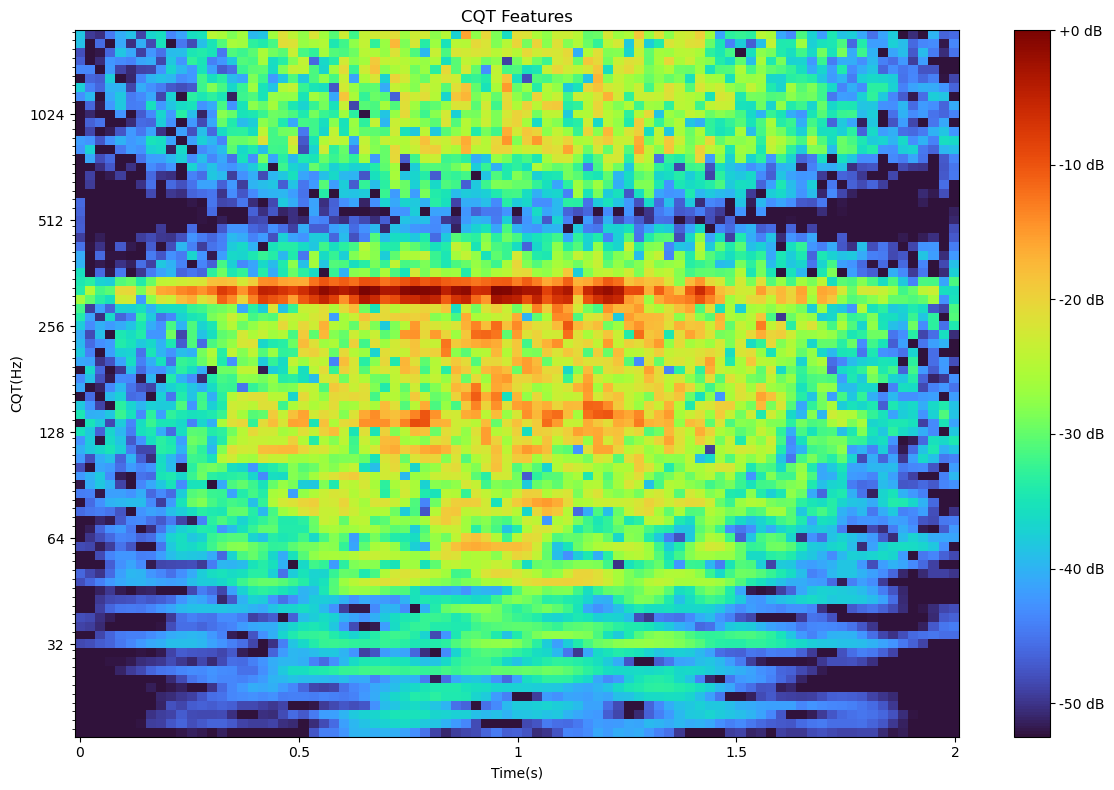

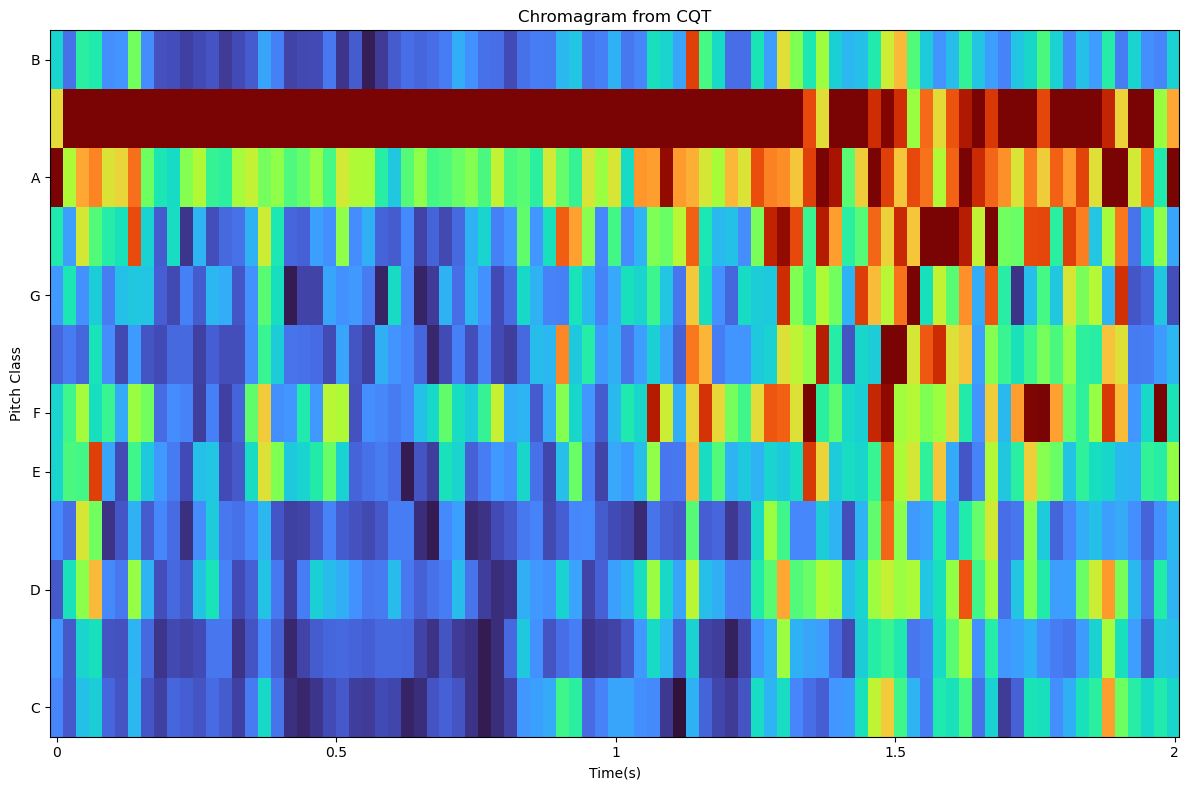

In [32]:
# 音频文件路径
audio_file = r'E:\数据集\ShipEar\data_preprocessing\3_Frame_Windows_2s_50%\6__10_07_13_marDeCangas_Entra_18.wav'

# 加载音频文件
waveform, original_sr = torchaudio.load(audio_file)

# 重采样
target_sr = 22050
if original_sr != target_sr:
    resampler = torchaudio.transforms.Resample(original_sr, target_sr)
    waveform = resampler(waveform)

# 创建CQT变换器
cqt_transformer = extract_cqt_transformer(target_sr)

# 提取CQT特征
cqt_features = cqt_transformer(waveform)

# 转换为numpy数组便于处理
cqt_data = cqt_features.detach().cpu().numpy()[0]

# 保存CQT特征到CSV
save_cqt_to_csv(cqt_data, 'cqt_features.csv')

# 可视化CQT特征
plot_cqt_features(cqt_data, target_sr, 'cqt_features.png')

# 可视化Chromagram
chromagram = extract_chromagram_from_cqt(waveform, sample_rate)
plot_chromagram(chromagram, target_sr, 'cqt_chromagram.png')

# 提取CQT特征及其谐波特征
cqt_harmonics = extract_cqt_with_harmonics(waveform, target_sr)
